# Environment

In [80]:
import gc 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import importlib

import celloracle as co
co.__version__

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_celloracle/helpers")

import config
importlib.reload(config)
from config import *
n_cpus = 32

In [81]:
reference = "hg19"

neurons_set = "all_inhibitory_all_ages"
# neurons_set = "all_inhibitory"

cells_dict = {
    "all_inhibitory"            :   ['SST', 'VIP', 'MGE_dev'],
    "all_inhibitory_all_ages"   :   ['VIP', 'SST', 'PV', 'MGE_dev']
}

ages_dict = {
    "all_inhibitory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_inhibitory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

output_dir, input_dir, root_dir, tmp_dir, in_dir_from_scenic = set_custom_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_inhibitory_all_ages/celloracle
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/celloracle/tmp


In [82]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Load data

## Load scRNA-seq data

In [83]:
adata = sc.read_h5ad(os.path.join(output_dir, 'subseted_rna_andata.h5ad'))
print(adata)
print(adata.var.shape)
print(adata.obs.shape)

AnnData object with n_obs × n_vars = 4422 × 25854
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_CLDN5_de

In [84]:
print([f"{celltype}: {len(adata.obs.major_clust[adata.obs.major_clust==celltype])}" for celltype in adata.obs.major_clust.unique()])

['MGE_dev: 1068', 'VIP: 1303', 'PV: 672', 'SST: 1379']


### Add genes of interests

In [85]:
toadd = ['RARA', 'ESR2', 'THRB']
print(len(toadd))

hvgs = list(adata.var_names[adata.var['highly_variable']])
print(len(hvgs))

3
3000


In [86]:
diff = list(set(toadd).difference(set(hvgs)))
intersec = list(set(toadd).intersection(set(hvgs)))
print(len(diff))
print(len(intersec))

2
1


In [87]:
values_to_remove = list(set(toadd).difference(set(adata.var_names)))
print(len(values_to_remove))

toadd = [item for item in toadd if item not in values_to_remove]

0


In [88]:
hvgs.extend(toadd)
hvgs = pd.Series(hvgs).unique()
print(len(hvgs))


3002


In [89]:
# adata = adata[:, adata.var['highly_variable']]
adata = adata[:, hvgs]
adata

View of AnnData object with n_obs × n_vars = 4422 × 3002
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust', 'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj', 'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj', 'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj', 'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj', 'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj', 'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj', 'Micro_dev-traj', 'OPC_dev-traj', 'OPC_MBP_dev-traj', 'Oligo_dev-traj', 'Vas_C

In [90]:
gc.collect()

30066

# CellOracle

## Init CellOracle object

In [91]:
oracle = co.Oracle()

In [92]:
oracle.import_anndata_as_raw_count(adata,
                                   cluster_column_name="major_clust",
                                   embedding_name="X_umap")

In [93]:
oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 4422
    n_genes: 3002
    cluster_name: major_clust
    dimensional_reduction_name: X_umap
    n_target_genes_in_TFdict: 0 genes
    n_regulatory_in_TFdict: 0 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 0 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 0 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Not imported
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

In [94]:
# base_GRN = co.data.load_human_promoter_base_GRN() 
# base_GRN = pd.read_parquet("./data/2023_11_tfi.celloracle.parquet", engine='pyarrow')
# base_GRN = pd.read_parquet(os.path.join(output_dir, "Herring_motif_scan.celloracle.parquet"), engine='pyarrow')

In [95]:
cell_type = sel_celltypes[0]

file_path = os.path.join(output_dir, f"{cell_type}.celloracle.parquet")
base_GRN = pd.read_parquet(file_path, engine='pyarrow')


base_GRN.head()

,peak_id,gene_short_name,AC023509.3,AC138696.1,AHR,AIRE,ALX1,ALX3,ALX4,ANHX,...,ZSCAN16,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN31,ZSCAN4,ZSCAN5,ZSCAN5C,ZSCAN9,ZZZ3
0,chr10_101088810_101089310,CNNM1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,chr10_101190241_101190741,GOT1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_101380007_101380507,SLC25A28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr10_101418869_101419369,ENTPD7,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_101491721_101492221,CUTC,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [97]:
External_data = pd.read_csv(os.path.join(input_dir, "2023_11_CellOracleProof.tsv"),delimiter="\t")
External_data

,TF,Target_genes
0,ADSL,"ATOH1,FBXO32,SSTR2,KALRN,AP003049.2,S100A11,MY..."
1,AKAP8,"AC073050.1,AC092069.1,AC092957.1,ACAT2,ADCY8,A..."
2,ANKLE2,"ADGRL4,LINC00682,PHOX2B,TMEM163,LRRC75A,LRP2,DLK1"
3,BBIP1,"ADGRL4,AP003049.2,CDH20,DLL3,SFRP1,UBE2C,TPX2,..."
4,DCHS1,"AC096711.2,FAM181B,AC092069.1,LMO2,AC092957.1,..."
5,HTT,"AC068308.1,AC090015.1,AC092957.1,AC092958.1,AC..."
6,KIF15,"LRRC75A,AC092069.1,PDZRN4,ADGRL4,RHOJ,NFIA,CBL..."
7,KIF18A,"ANGPT1,ATAD5,ATP5F1E,BMP5,BTBD17,CBLN1,CCDC102..."
8,KNL1,"CHSY3,SGCZ,DPYD,ADGRL4,LINC01965,FABP7,NKAIN3,..."
9,MTUS1,"ACAT2,ACTA2,ADGRL2,ADM,AIF1,AL357507.1,ANGPT1,..."


In [98]:
TF_to_TG_dictionary = {}

for TF, TGs in zip(External_data.TF, External_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)

oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

  0%|          | 0/571 [00:00<?, ?it/s]

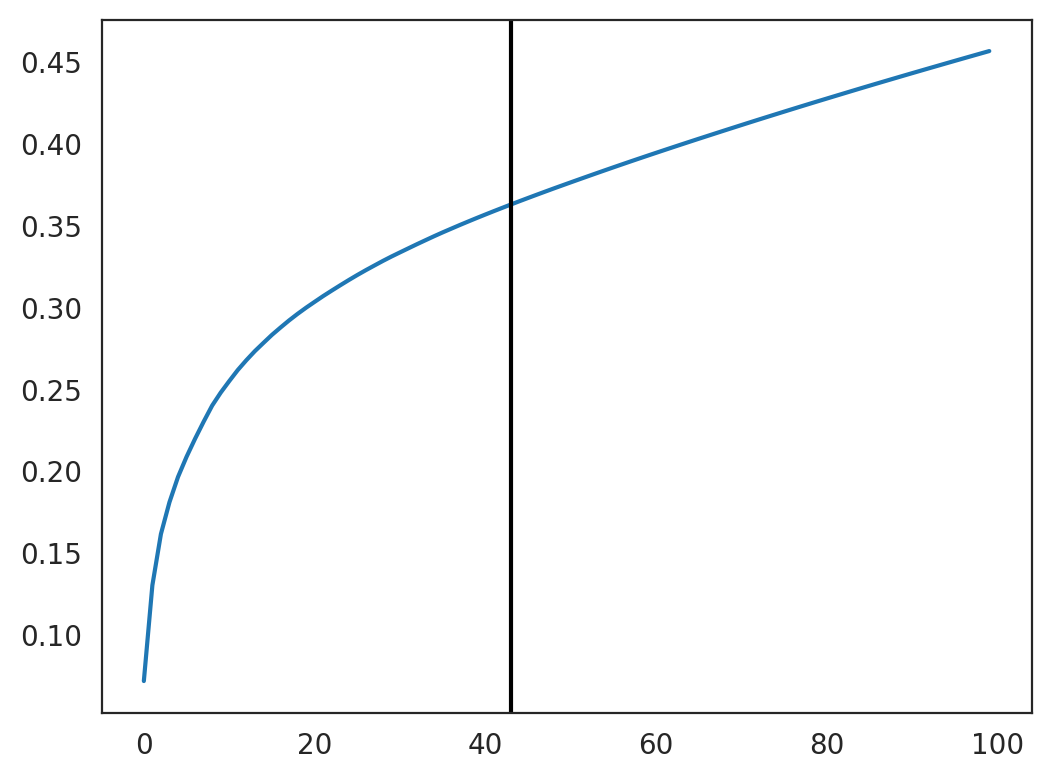

43


In [99]:
oracle.perform_PCA()

plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [100]:
gc.collect()

3134

In [101]:
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=n_cpus)

Auto-selected k is :110


In [102]:
sc.pp.neighbors(oracle.adata)

In [103]:
sc.tl.umap(oracle.adata) #, min_dist=0.3

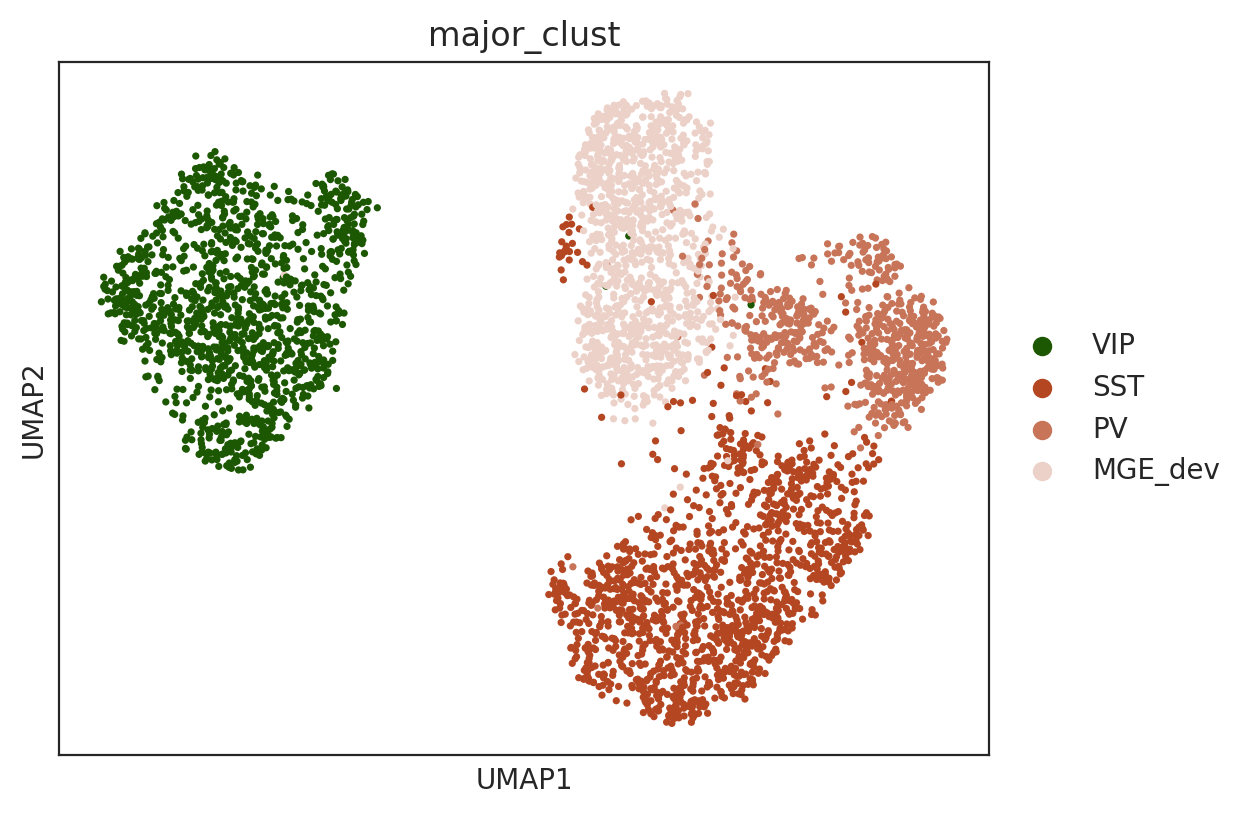

In [104]:
sc.pl.umap(oracle.adata, color = "major_clust", layer="imputed_count")

In [105]:
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = os.path.join(output_dir, f"oracle_1.celloracle.oracle")
oracle.to_hdf5(file_name)

In [106]:
gc.collect()

21178

## Inferring GRN

In [107]:
links = oracle.get_links(cluster_name_for_GRN_unit="major_clust", alpha=10,
                         verbose_level=10, n_jobs=n_cpus)

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for MGE_dev...


  0%|          | 0/847 [00:00<?, ?it/s]

Inferring GRN for PV...


  0%|          | 0/847 [00:00<?, ?it/s]

Inferring GRN for SST...


  0%|          | 0/847 [00:00<?, ?it/s]

Inferring GRN for VIP...


  0%|          | 0/847 [00:00<?, ?it/s]

In [108]:
links.links_dict.keys()

dict_keys(['MGE_dev', 'PV', 'SST', 'VIP'])

In [109]:
links.filter_links()
# links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)


In [110]:
links.get_network_score()

In [111]:
links.merged_score.head()

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
PROX1,31,0.036385,5,0.005869,26,0.030516,0.0,0.192645,MGE_dev
KIRREL3,5,0.005869,5,0.005869,0,0.000000,0.0,0.233875,MGE_dev
FOSB,59,0.069249,0,0.000000,59,0.069249,0.0,0.172038,MGE_dev
MGAT4C,4,0.004695,4,0.004695,0,0.000000,0.0,0.160333,MGE_dev
ZNF385D,160,0.187793,3,0.003521,157,0.184272,1646.0,0.349035,MGE_dev


In [112]:
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = os.path.join(output_dir, f"links_1.celloracle.links")
links.to_hdf5(file_path=file_name)

In [113]:
# file_name = os.path.join(output_dir, "Herring_links_20240404_160414.celloracle.links")
# links = co.load_hdf5(file_name)

In [114]:
plt.rcParams["figure.figsize"] = [9, 4.5]

MGE_dev


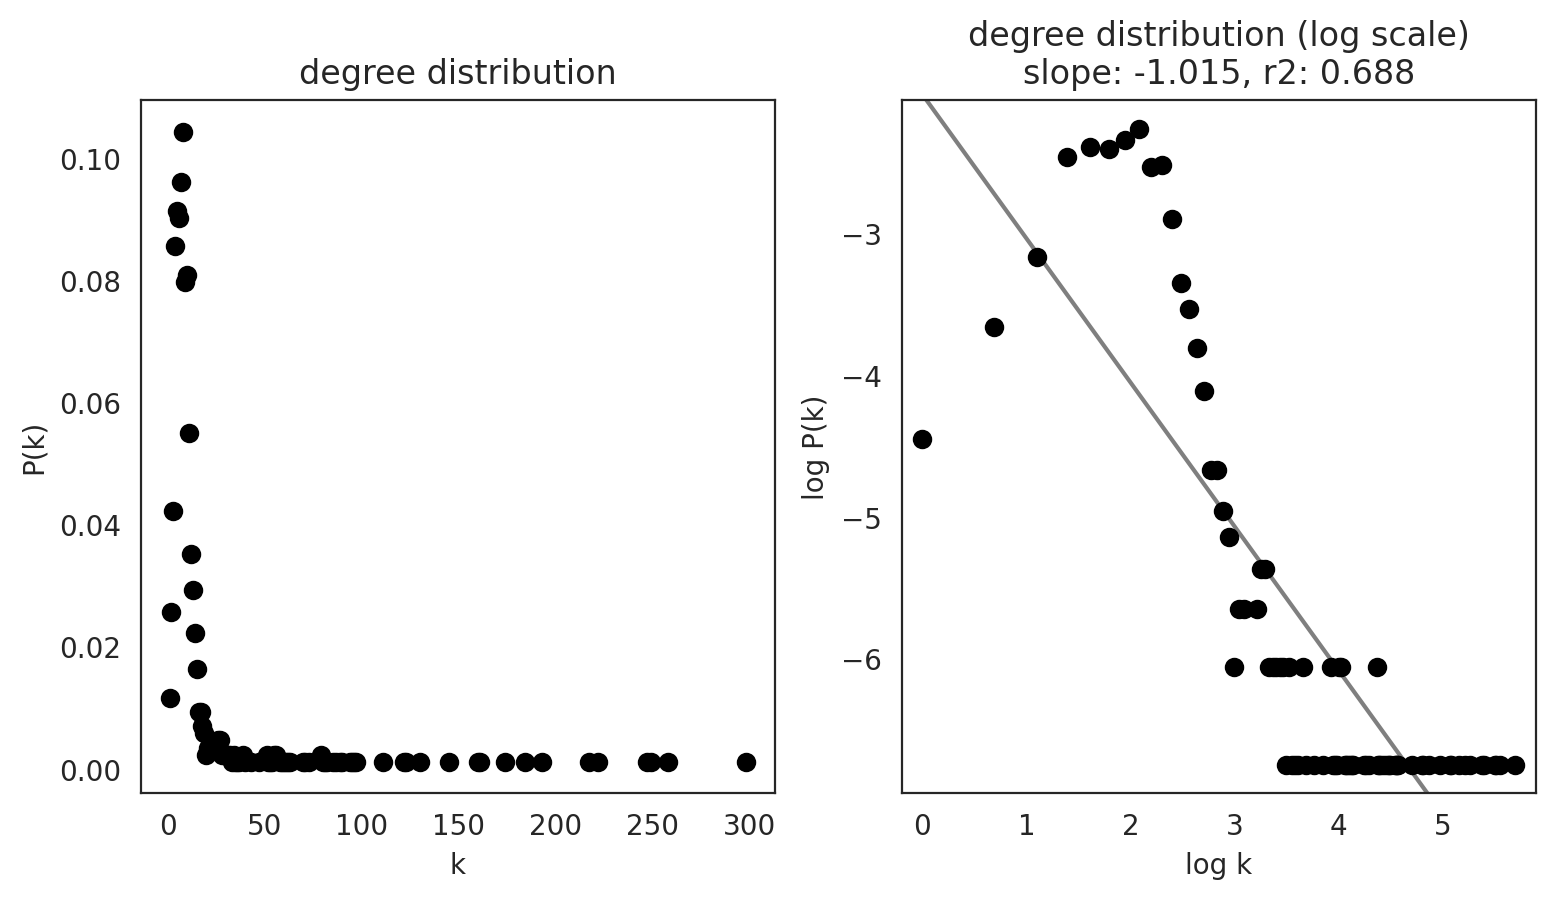

PV


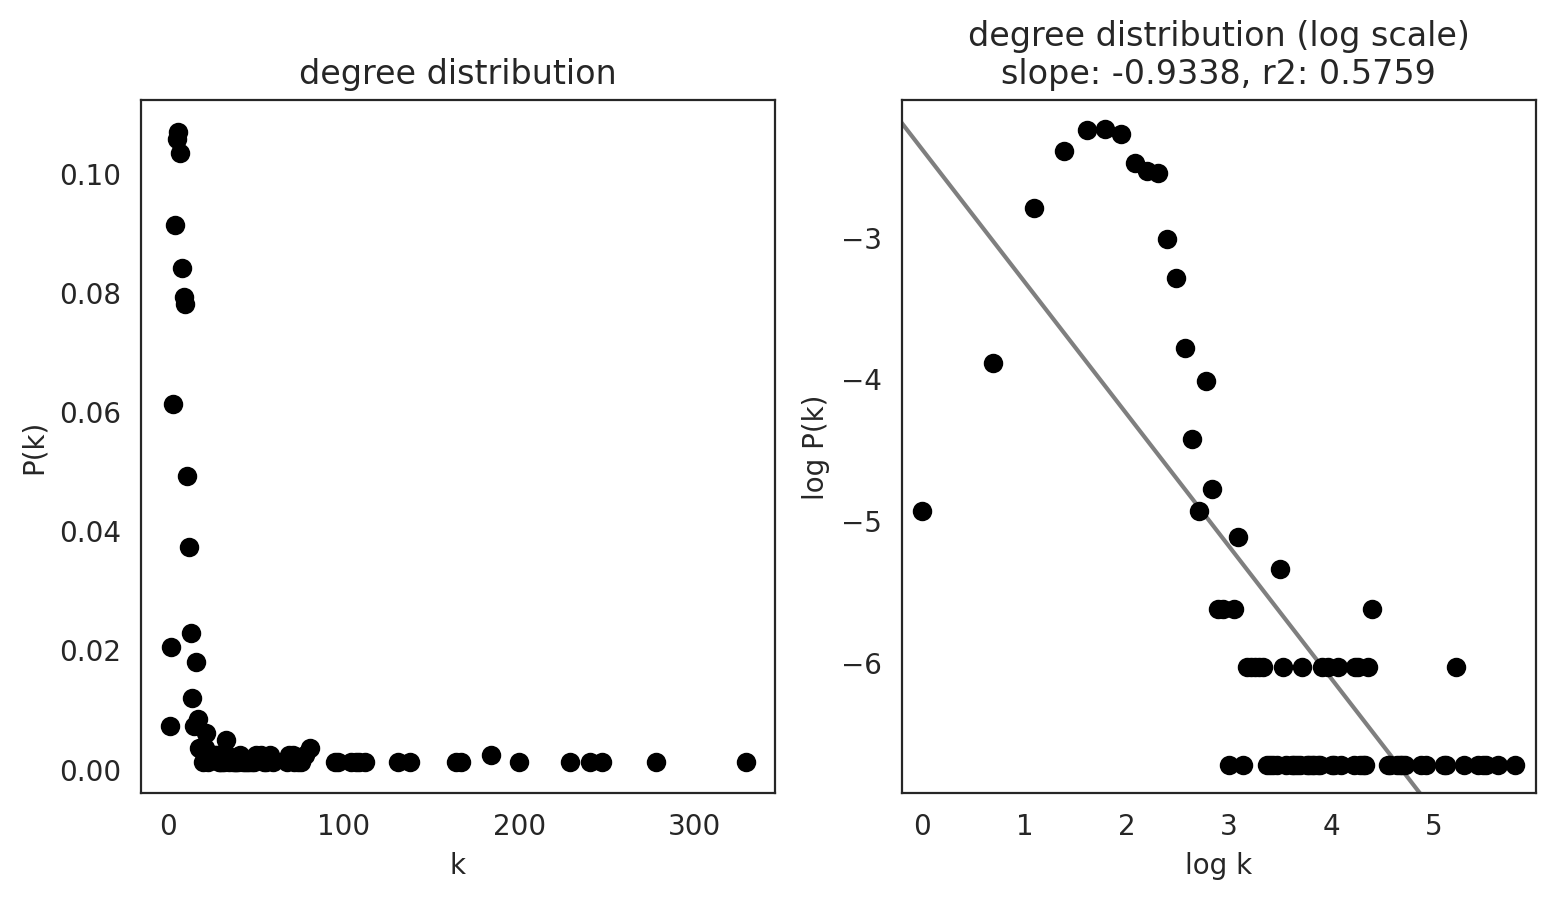

SST


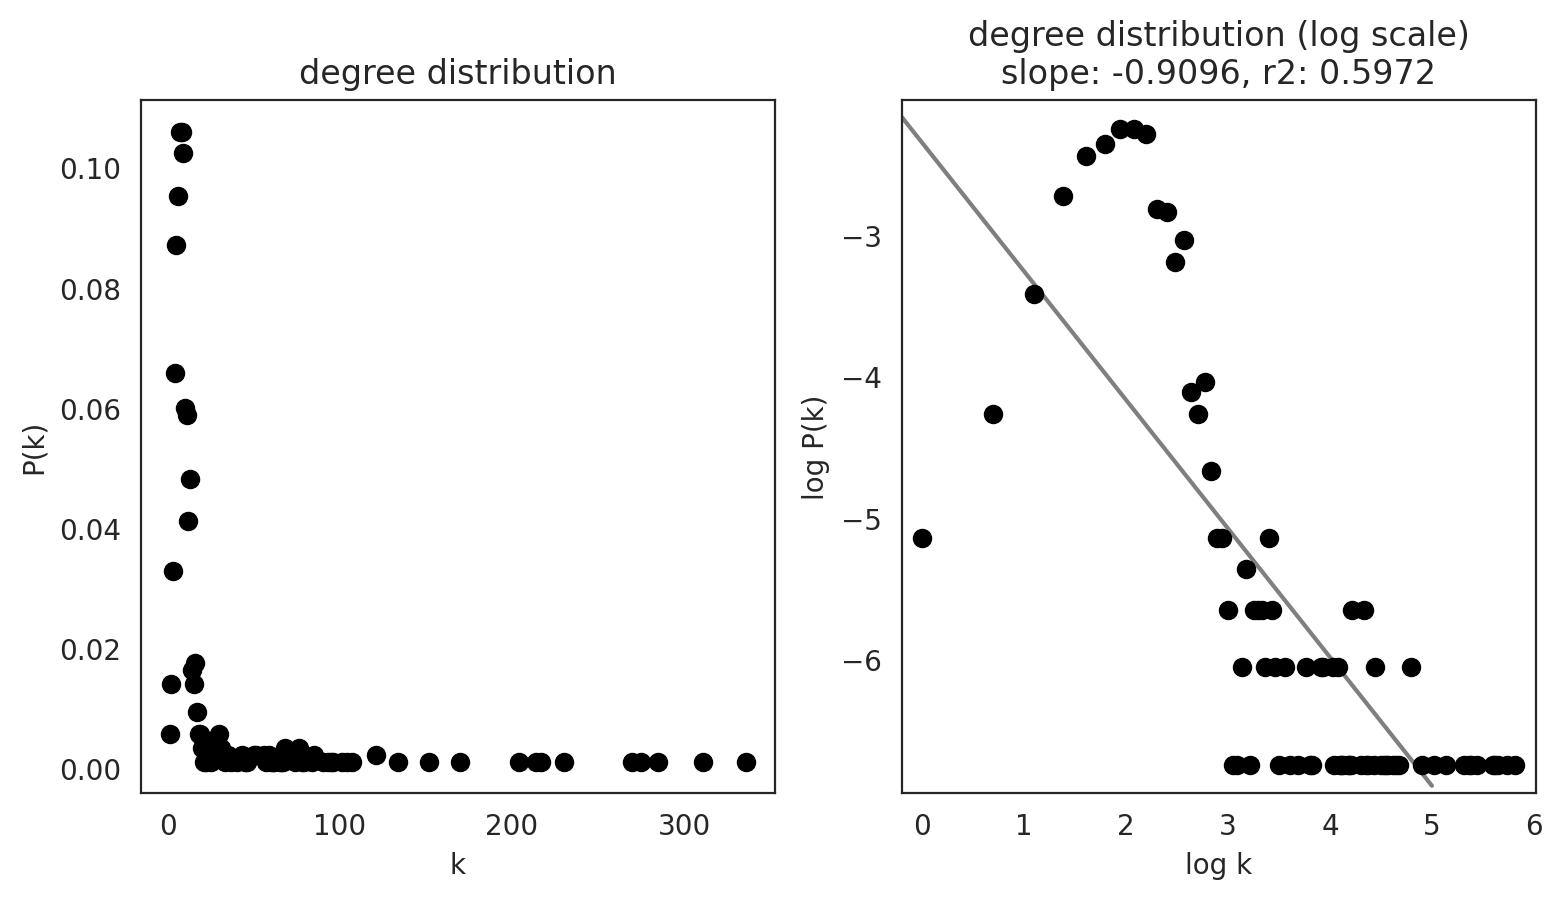

VIP


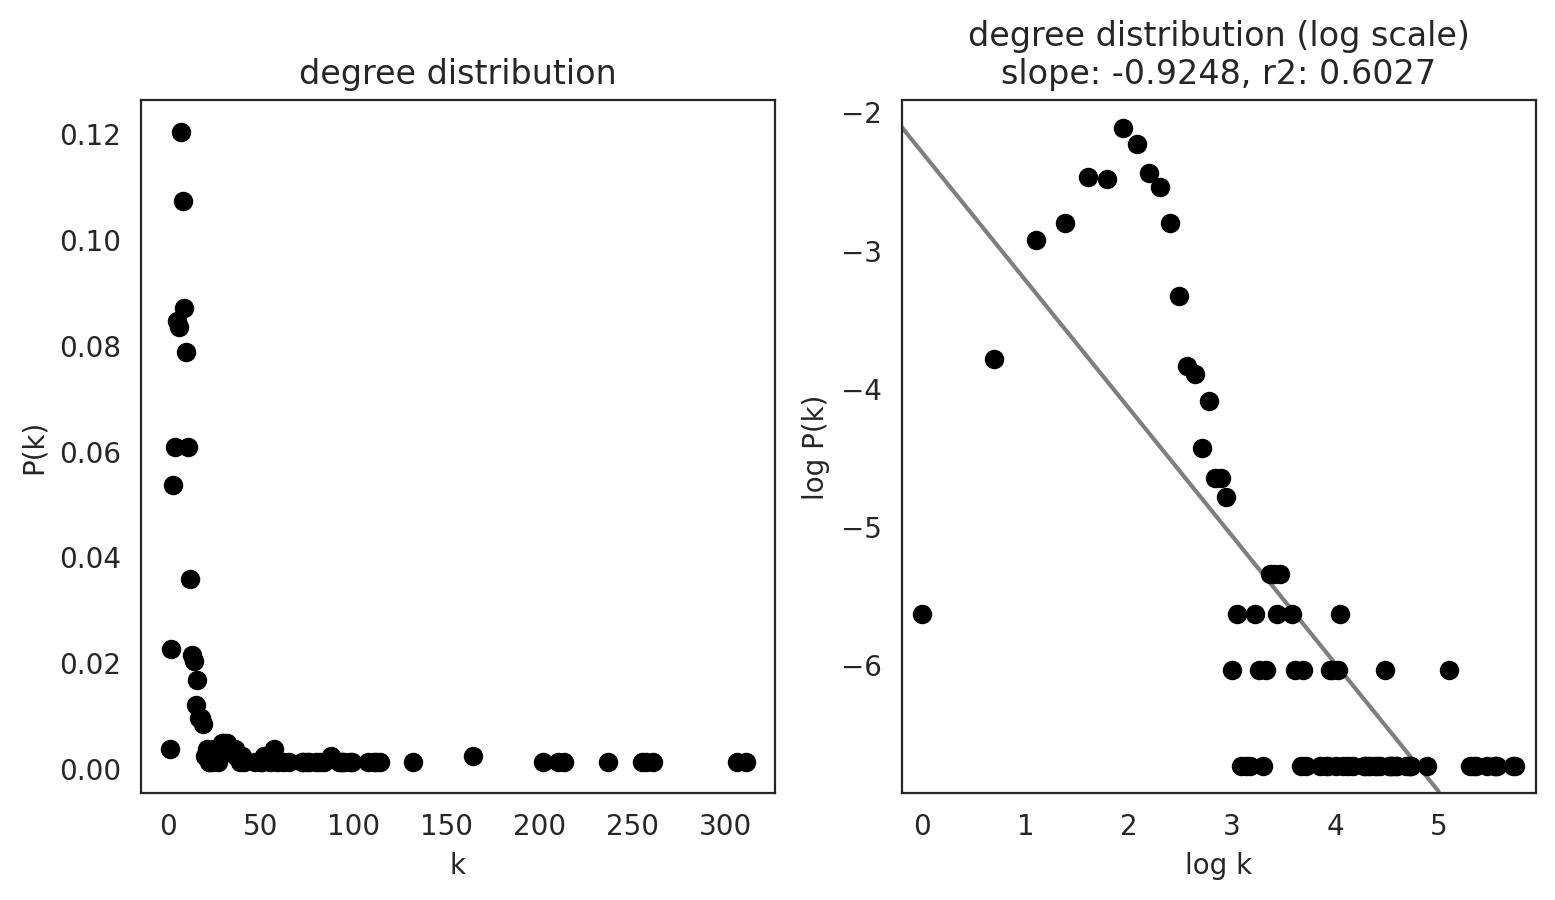

In [115]:
links.plot_degree_distributions(plot_model=True)

In [116]:
plt.rcParams["figure.figsize"] = [6, 4.5]

In [117]:
links.cluster

['MGE_dev', 'PV', 'SST', 'VIP']

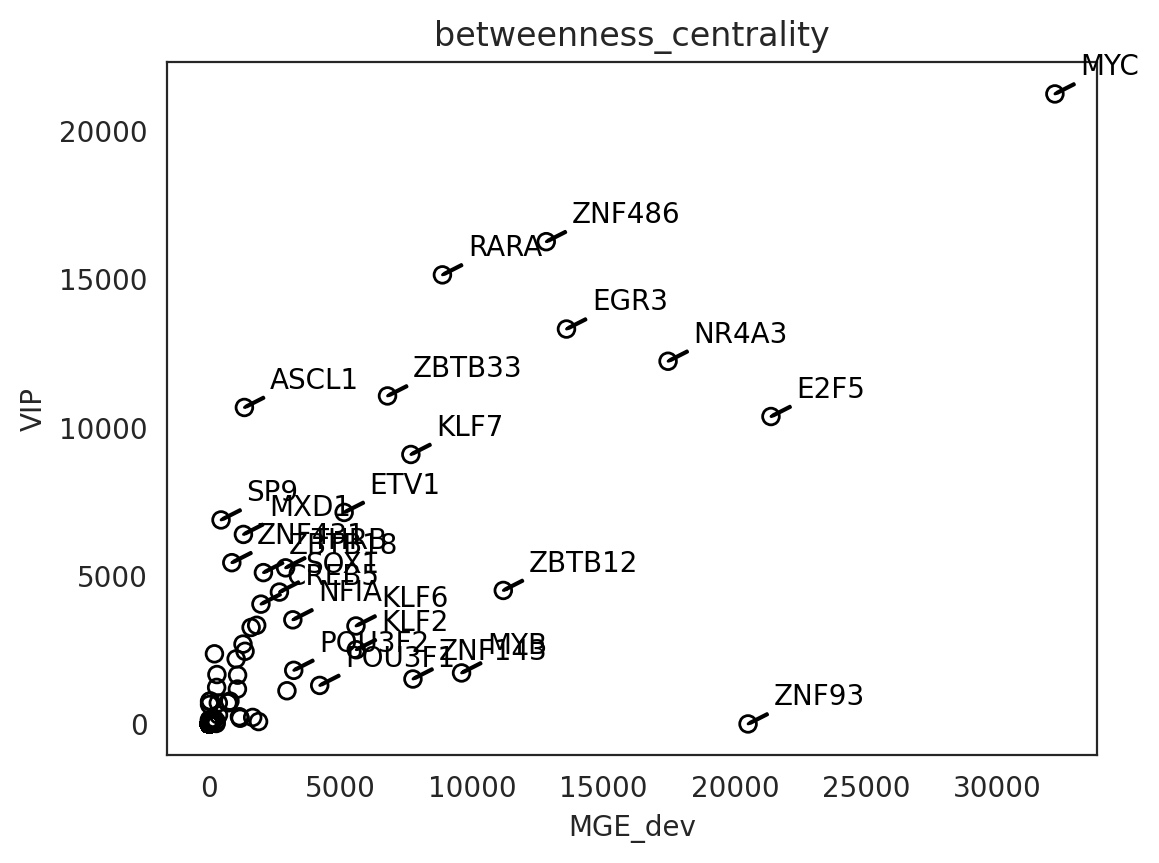

In [118]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="MGE_dev", cluster2="VIP",
                               percentile=98)
